## √âchiquier 3D avec coins internes

Ce code g√©n√®re un √©chiquier 3D pour la calibration cam√©ra.

**Surface** : alternance de carr√©s noirs et blancs.

**Coins internes** : plac√©s en rouge (√† partir de la 2e ligne/colonne) pour la calibration.

**Rep√®re monde** : X (rouge), Y (vert), Z (bleu).

**Sortie** : liste des points 3D `(x, y, z)` des coins internes, tous √† `z = 0`.

Utilis√© pour simuler un plan de calibration dans un espace 3D.


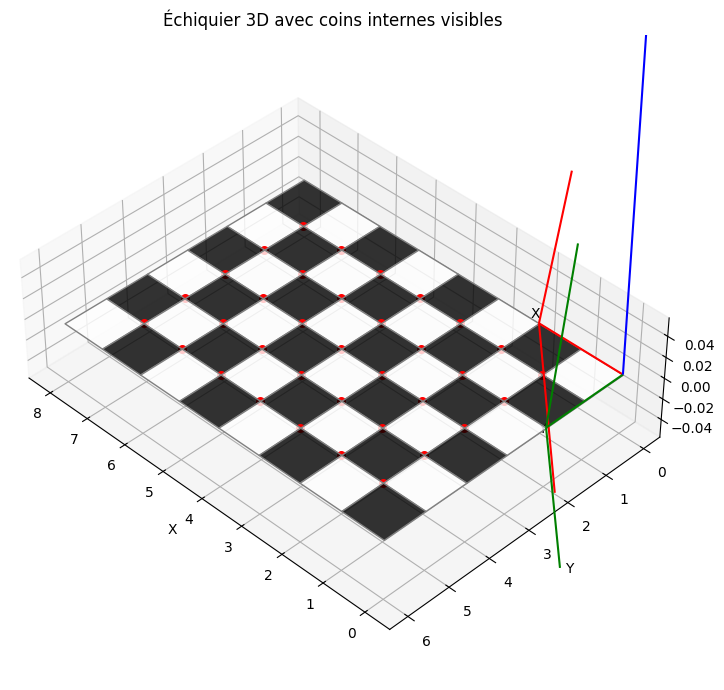

Points projet√©s 3D :
[[1. 1. 0.]
 [2. 1. 0.]
 [3. 1. 0.]
 [4. 1. 0.]
 [5. 1. 0.]
 [6. 1. 0.]
 [7. 1. 0.]
 [1. 2. 0.]
 [2. 2. 0.]
 [3. 2. 0.]
 [4. 2. 0.]
 [5. 2. 0.]
 [6. 2. 0.]
 [7. 2. 0.]
 [1. 3. 0.]
 [2. 3. 0.]
 [3. 3. 0.]
 [4. 3. 0.]
 [5. 3. 0.]
 [6. 3. 0.]
 [7. 3. 0.]
 [1. 4. 0.]
 [2. 4. 0.]
 [3. 4. 0.]
 [4. 4. 0.]
 [5. 4. 0.]
 [6. 4. 0.]
 [7. 4. 0.]
 [1. 5. 0.]
 [2. 5. 0.]
 [3. 5. 0.]
 [4. 5. 0.]
 [5. 5. 0.]
 [6. 5. 0.]
 [7. 5. 0.]]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def generate_chessboard_3d(nx=8, ny=6, square_size=1.0):
    """
    G√©n√®re un √©chiquier 3D avec coins internes visibles.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # === √âCHIQUIER (surface)
    for i in range(ny):
        for j in range(nx):
            color = 'white' if (i + j) % 2 == 0 else 'black'
            square = [
                [j*square_size,     i*square_size,     0],
                [(j+1)*square_size, i*square_size,     0],
                [(j+1)*square_size, (i+1)*square_size, 0],
                [j*square_size,     (i+1)*square_size, 0]
            ]
            ax.add_collection3d(Poly3DCollection([square], facecolors=color, edgecolors='gray', alpha=0.8))

    # === COINS INTERNES (pour calibration) ===
    object_points = []
    for i in range(1, ny):
        for j in range(1, nx):
            x = j * square_size
            y = i * square_size
            z = 0
            object_points.append([x, y, z])
            ax.scatter(x, y, z, c='red', s=30)

    # === REP√àRE MONDE
    ax.quiver(0, 0, 0, 2, 0, 0, color='r')  # X
    ax.quiver(0, 0, 0, 0, 2, 0, color='g')  # Y
    ax.quiver(0, 0, 0, 0, 0, 2, color='b')  # Z
    ax.text(2.2, 0, 0, 'X')
    ax.text(0, 2.2, 0, 'Y')
    ax.text(0, 0, 2.2, 'Z')

    ax.set_title('√âchiquier 3D avec coins internes visibles')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=40, azim=135)
    ax.set_box_aspect([1, ny/nx, 0.3])
    plt.tight_layout()
    plt.show()

    return np.array(object_points)

# G√©n√©ration et affichage
object_points = generate_chessboard_3d()
# Affichage
print("Points projet√©s 3D :")
print(object_points)  



## Projection 2D des points 3D (vue dessus)

Extraction des coordonn√©es `(x, y)` √† partir des points 3D.

Affichage d'une projection 2D simul√©e (vue du dessus).

Inversion de l'axe Y pour correspondre √† l‚Äôorientation image.

Les points 2D simul√©s sont affich√©s et visualis√©s en rouge.


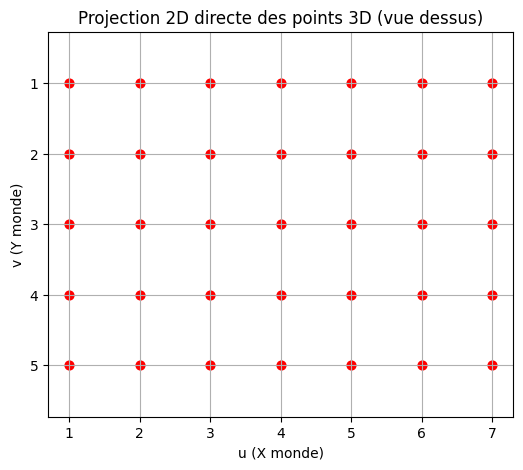

Points 2D simul√©s :
[[1. 1.]
 [2. 1.]
 [3. 1.]
 [4. 1.]
 [5. 1.]
 [6. 1.]]


In [3]:
# === Extraction des coordonn√©es 2D (X, Y) ===
image_points_2d = object_points[:, :2]  # On garde juste (x, y)

plt.figure(figsize=(6, 5))
plt.scatter(image_points_2d[:, 0], image_points_2d[:, 1], c='red', s=40)
plt.title("Projection 2D directe des points 3D (vue dessus)")
plt.xlabel("u (X monde)")
plt.ylabel("v (Y monde)")
plt.gca().invert_yaxis()  
plt.axis('equal')
plt.grid(True)
plt.show()

# === Affichage des coordonn√©es 2D
print("Points 2D simul√©s :")
print(image_points_2d[:6])  # Affiche les 5 premiers

### Explication du Code
 Ce code permet d'estimer la matrice de projection d'une cam√©ra √† partir de correspondances entre des points 3D et 2D, puis de d√©composer cette matrice en ses param√®tres intrins√®ques, de rotation et de translation. Il comporte trois √©tapes principales :

Construction des matrices 
ùê¥ et 
b : √Ä partir de 6 correspondances de points 3D et 2D, la fonction g√©n√®re les matrices 

Estimation de 
S
et 
M
 : R√©solution du syst√®me 
A
√ó
S
= b

A√óS=b pour obtenir les coefficients de la matrice de projection 
M.

D√©composition de M en trois matrices : 

K (intrins√®que), 

R (rotation) et 

T (translation).

Le code affiche les matrices A, b, M, et les r√©sultats de la d√©composition K, R et T.


In [14]:
import numpy as np
from scipy.linalg import rq

# Fonction pour construire A et b √† partir des points 3D et 2D
def construire_A_b_6_points(points_3d, points_2d):
    """
    Construit A (12x11) et b (12x1) pour les 6 premi√®res correspondances.
    """
    A = []
    b = []

    for i in range(6):  # Utilise seulement 6 points
        X, Y, Z = points_3d[i]
        u, v = points_2d[i]

        A.append([X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z])
        A.append([0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z])
        b.append(u)
        b.append(v)

    return np.array(A), np.array(b)

# Fonction pour estimer S et M √† partir de A et b
def estimer_S_et_M_depuis_6_points(A, b):
    """
    R√©sout A*S = b pour 11 inconnues, puis reconstruit M (3x4).
    """
    S, _, _, _ = np.linalg.lstsq(A, b, rcond=None)  # S est de taille (11,)

    print("\nVecteur S estim√© (taille 11) :")
    print(S)

    # Ajouter le 12e √©l√©ment fix√© √† 1 pour reconstruire M
    S_complet = np.append(S, 1.0)
    M = S_complet.reshape((3, 4))
    return S, M

# Fonction pour d√©composer une matrice de projection M en K, R, T
def decompose_projection_matrix(M):
    """
    D√©compose une matrice de projection M (3x4) en :
    - K : matrice intrins√®que (3x3)
    - R : matrice de rotation (3x3)
    - T : vecteur de translation (3x1)
    """
    # Sous-matrice 3x3
    M_3x3 = M[:, :3]

    # RQ d√©composition : M = K @ R
    K, R = rq(M_3x3)

    # S'assurer que la diagonale de K est positive
    T_sign = np.sign(np.diag(K))
    T_sign[T_sign == 0] = 1
    D = np.diag(T_sign)
    K = K @ D
    R = D @ R

    # Translation : t = K‚Åª¬π * M[:,3]
    T = np.linalg.inv(K) @ M[:, 3]

    return K, R, T

# === Construction des matrices A et b pour les 6 premiers points ===
A_6, b_6 = construire_A_b_6_points(object_points, image_points_2d)

# === Estimation de la matrice de projection M_6 ===
S_6, M_6 = estimer_S_et_M_depuis_6_points(A_6, b_6)

# === D√©composition de la matrice M_6 ===
K, R, T = decompose_projection_matrix(M_6)

# === Affichages ===
print("\nMatrice A (12x11) :")
print(A_6)

print("\nVecteur b (12 valeurs) :")
print(b_6)

print("\nMatrice de projection M estim√©e (3x4) :")
print(M_6)

print("\nMatrice intrins√®que K :")
print(K)

print("\nMatrice de rotation R :")
print(R)

print("\nVecteur de translation T :")
print(T)



Vecteur S estim√© (taille 11) :
[ 4.00000000e-01 -1.80411242e-16 -2.70616862e-16 -1.78676518e-16
 -1.17961196e-16  2.00000000e-01  0.00000000e+00  2.00000000e-01
 -2.35922393e-16 -6.00000000e-01  0.00000000e+00]

Matrice A (12x11) :
[[  1.   1.   0.   1.   0.   0.   0.   0.  -1.  -1.  -0.]
 [  0.   0.   0.   0.   1.   1.   0.   1.  -1.  -1.  -0.]
 [  2.   1.   0.   1.   0.   0.   0.   0.  -4.  -2.  -0.]
 [  0.   0.   0.   0.   2.   1.   0.   1.  -2.  -1.  -0.]
 [  3.   1.   0.   1.   0.   0.   0.   0.  -9.  -3.  -0.]
 [  0.   0.   0.   0.   3.   1.   0.   1.  -3.  -1.  -0.]
 [  4.   1.   0.   1.   0.   0.   0.   0. -16.  -4.  -0.]
 [  0.   0.   0.   0.   4.   1.   0.   1.  -4.  -1.  -0.]
 [  5.   1.   0.   1.   0.   0.   0.   0. -25.  -5.  -0.]
 [  0.   0.   0.   0.   5.   1.   0.   1.  -5.  -1.  -0.]
 [  6.   1.   0.   1.   0.   0.   0.   0. -36.  -6.  -0.]
 [  0.   0.   0.   0.   6.   1.   0.   1.  -6.  -1.  -0.]]

Vecteur b (12 valeurs) :
[1. 1. 2. 1. 3. 1. 4. 1. 5. 1. 6. 1.]

Matr

## La mise en correspendance d un objet avec la methode de relaxation dans le but d une reconstitution 3D:

Ce code effectue une correspondance de points cl√©s entre deux images en utilisant ORB (Oriented FAST and Rotated BRIEF) pour d√©tecter les points cl√©s et leurs descripteurs, et ensuite trouve les correspondances dans un voisinage d√©fini autour de chaque point cl√©.

Les deux images sont charg√©es √† partir des chemins sp√©cifi√©s.

Elles sont ensuite converties en images en niveaux de gris.

ORB est utilis√© pour d√©tecter un maximum de 5000 points cl√©s et calculer les descripteurs associ√©s pour chaque image.

Pour chaque point cl√© d√©tect√© dans la premi√®re image, un voisinage de points dans la deuxi√®me image est d√©fini autour de ce point.

Les descripteurs des points voisins sont extraits et compar√©s au descripteur du point cl√© de la premi√®re image.

La meilleure correspondance est choisie parmi les voisins qui satisfont la condition de relaxation : le point voisin le plus proche doit √™tre nettement plus proche que le second plus proche.

Une fois la meilleure correspondance trouv√©e, elle est affich√©e sur les deux images avec `cv2.drawMatches()`. La correspondance est visualis√©e sur un graphique avec `matplotlib`.


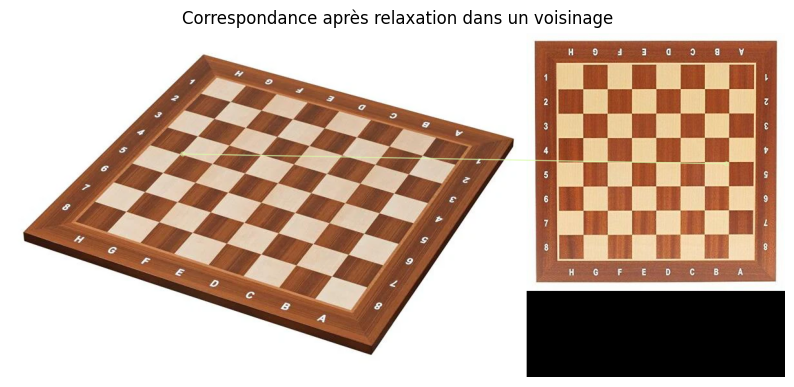

Point 2D dans image 1 : (267.00, 188.00)
Point 2D correspondant dans image 2 : (308.97, 203.21)


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger les deux images
img1 = cv2.imread(r'C:\Users\DELL\Desktop\view1.webp')
img2 = cv2.imread(r'C:\Users\DELL\Desktop\view2.jpg')

# Convertir les images en niveaux de gris
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# 1. D√©tecter les points cl√©s avec ORB
orb = cv2.ORB_create(5000)
kp1, des1 = orb.detectAndCompute(gray1, None)
kp2, des2 = orb.detectAndCompute(gray2, None)

# D√©finir la taille du voisinage
neighborhood_size = 50  # Taille du voisinage (en pixels)

# 3. Trouver la meilleure correspondance dans le voisinage
best_match = None
min_distance = float('inf')

for i, des1_point in enumerate(des1):
    # Obtenir les coordonn√©es du point cl√© dans la premi√®re image
    x1, y1 = kp1[i].pt
    
    # D√©finir les limites du voisinage dans la deuxi√®me image
    x1_min = max(0, int(x1 - neighborhood_size))
    x1_max = min(gray2.shape[1], int(x1 + neighborhood_size))
    y1_min = max(0, int(y1 - neighborhood_size))
    y1_max = min(gray2.shape[0], int(y1 + neighborhood_size))
    
    # Extraire les indices des points cl√©s dans le voisinage dans la deuxi√®me image
    neighbor_kp_indices = []
    for j, kp2_point in enumerate(kp2):
        x2, y2 = kp2_point.pt
        if x1_min <= x2 <= x1_max and y1_min <= y2 <= y1_max:
            neighbor_kp_indices.append(j)
    
    # Extraire les descripteurs du voisinage dans la deuxi√®me image
    if len(neighbor_kp_indices) > 1:  # V√©rifier qu'il y a plus d'un voisinage
        neighborhood = des2[neighbor_kp_indices]
        
        # Calculer les distances uniquement dans cette r√©gion de voisinage
        distances = np.linalg.norm(neighborhood - des1_point, axis=1)
        
        # Trier les voisins par distance croissante
        sorted_indices = np.argsort(distances)
        
        # V√©rifier la condition de relaxation (seulement si il y a plus d'un voisin)
        if len(sorted_indices) > 1 and distances[sorted_indices[0]] < distances[sorted_indices[1]]:  
            if distances[sorted_indices[0]] < min_distance:
                min_distance = distances[sorted_indices[0]]
                best_match = cv2.DMatch(i, neighbor_kp_indices[sorted_indices[0]], min_distance)

# 4. Afficher le meilleur match
if best_match:
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, [best_match], None, flags=2)
    plt.figure(figsize=(10,5))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title('Correspondance apr√®s relaxation dans un voisinage')
    plt.axis('off')
    plt.show()
# 4. Afficher le meilleur match
if best_match:
    # Extraire les coordonn√©es 2D des points correspondants
    pt1 = kp1[best_match.queryIdx].pt
    pt2 = kp2[best_match.trainIdx].pt

    # Afficher les coordonn√©es arrondies √† 2 d√©cimales
    print(f"Point 2D dans image 1 : ({pt1[0]:.2f}, {pt1[1]:.2f})")
    print(f"Point 2D correspondant dans image 2 : ({pt2[0]:.2f}, {pt2[1]:.2f})")

    

Cr√©er l'objet de calcul de disparit√© (l'algorithme Block Matching)

Calculer la carte de disparit√©

Normaliser la carte de disparit√© pour une visualisation

Afficher la carte de disparit√©

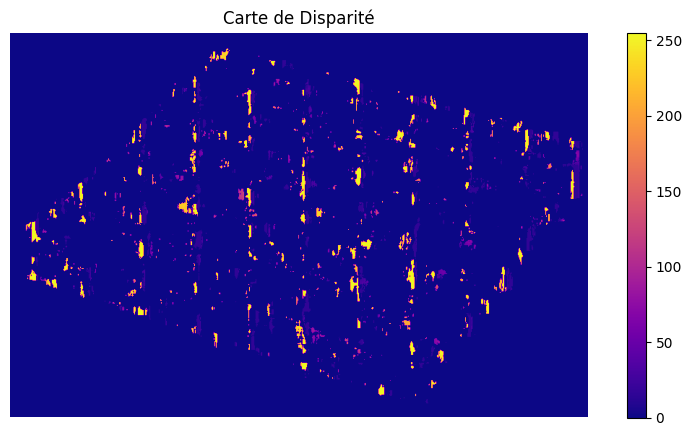

In [18]:
# Charger les deux images
img1 = cv2.imread(r'C:\Users\DELL\Desktop\view1.webp')
img2 = cv2.imread(r'C:\Users\DELL\Desktop\view2.jpg')

# Redimensionner les images pour qu'elles aient la m√™me taille
height, width = img1.shape[:2]
img2_resized = cv2.resize(img2, (width, height))

# Convertir les images en niveaux de gris
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2_resized, cv2.COLOR_BGR2GRAY)

# Cr√©er l'objet de calcul de disparit√© (ici, l'algorithme Block Matching)
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)

# Calculer la carte de disparit√©
disparity = stereo.compute(gray1, gray2)

# Normaliser la carte de disparit√© pour une visualisation
disparity_normalized = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX)
disparity_normalized = np.uint8(disparity_normalized)

# Afficher la carte de disparit√©
plt.figure(figsize=(10, 5))
plt.imshow(disparity_normalized, cmap='plasma')
plt.colorbar()
plt.title("Carte de Disparit√©")
plt.axis('off')
plt.show()


Exemple de matrices de projection

Pr√©parer les points homog√®nes 2D

Triangulation=le processus qui permet de reconstruire un point 3D √† partir de ses projections 2D dans deux images prises sous des angles diff√©rents, en utilisant les matrices de projection des cam√©ras et les coordonn√©es des points correspondants.

Convertir en coordonn√©es 3D (division par la coord homog√®ne)

Affichage du point 3D reconstruit

In [21]:
# Exemple de matrices de projection (√† adapter avec les tiennes !)
# P1 = K @ [I | 0] (cam√©ra 1 au centre du monde)
# P2 = K @ [R | t] (cam√©ra 2 d√©cal√©e par rotation R et translation t)
P1 = np.array([[1000, 0, 320, 0],
               [0, 1000, 240, 0],
               [0, 0, 1, 0]])

P2 = np.array([[1000, 0, 320, -100],
               [0, 1000, 240, 0],
               [0, 0, 1, 0]])

# Pr√©parer les points homog√®nes 2D (format (2, N))
pt1_h = np.array([[pt1[0]], [pt1[1]]], dtype=np.float32)
pt2_h = np.array([[pt2[0]], [pt2[1]]], dtype=np.float32)


# Triangulation
point_4d_hom = cv2.triangulatePoints(P1, P2, pt1_h, pt2_h)

# Convertir en coordonn√©es 3D (division par la coord homog√®ne)
point_3d = point_4d_hom[:3] / point_4d_hom[3]

# Affichage du point 3D reconstruit
print("Point 3D reconstruit :")
print(f"X = {point_3d[0][0]:.2f}, Y = {point_3d[1][0]:.2f}, Z = {point_3d[2][0]:.2f}")


Point 3D reconstruit :
X = nan, Y = nan, Z = nan
